### ALY6110 - Final Project on Big Data Analytics using European Soccer Leagues games data from Kaggel

#### Big Data is being used these days in Sports widely. Instead of relying on intuition, experience and anecdotes, sports participants and enthusiasts can examine data that tells the real story to help with every aspect of the game. Here in this project we are analyzing games from European Soccer Leagues.

#### Dataset Information
- Data source : "Kaggle"
- Data : European Soccer Leagues events
- Content: Granular view of 9,074 games
- Number of Records : 941009 rows and 22 columns
- Countries : England, Spain, Germany, Italy, and France
- Year: 2011 to 2016

#### Source
https://www.kaggle.com/secareanualin/football-events

#### Files
- events.csv contains event data about each game
- ginf.csv - contains metadata and market odds about each game.
- dictionary.txt contains a dictionary with the textual description of each categorical variable coded with integer.


#### The primary dataset is specific events from the games in chronological order, including key information like:

- id_odsp – unique identifier of game
- time – minute of the game
- event_type – primary event
- event_team – the team that produced the event
- player – name of the player involved in the main event
- shot_place – placement of the shot, 13 possible placement locations
- shot_outcome – 4 possible outcomes
- location – location on the pitch where the event happened, 19 possible locations
- is_goal – binary variable if the shot resulted in a goal (own goals included)
And more..

#### The second smaller dataset includes high-level information and advanced stats with one record per game.

Key attributes are “League”, “Season”, “Country”, “Home Team”, “Away Team” and various market odds.

#### Questions we tried to answer using this datasets
- Que1. Which are the places on field where maximum number of goals are scored ?

- Que 2. Which countries have scored maximum no. of goals in all tournaments ?

- Que 3. At what minutes most number of goals are scored?

- Que 4. At what minutes maximum number of yellow card were given ?

- Que 5. At what minutes maximum number of red card were given ?

- Que 6. At what time most number of substitution were made ?

- Que 7. Goal wise distribution of Location and shot place for 'Spain'

- Que 8. Goal distribution in different time bins for all countries

#### Approach taken for analysis
- 1 Data Exploration
- 2 Data Data Processing
    - Data Cleaning
    - Treating Null/Missing values
    - Getting rid of unwanted columns
- 3 Data Tranformations
- 4 Data Merge
- 5 Data Analysis
- 6 Data Visualization

#### References
- Grag.A.,(2018 July 9). Analyze Games from European Soccer Leagues with Apache Spark and Databricks
Retrieved from: https://databricks.com/blog/2018/07/09/analyze-games-from-european-soccer-leagues-with-apache-spark-and-databricks.html

- Secareanu.A.,(n.d.).Football Events. More than 900,000 events from 9,074 football games across Europe. Retrieved from :https://www.kaggle.com/secareanualin/football-events


In [1]:
# Create spark session
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
# Import data types
from pyspark.sql.types import *

sc = spark.sparkContext

In [3]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # more plotting

In [4]:
#Read the Events dataset
eventsDf = spark.read.options(header="true",\
                              inferSchema="true",\
                              nullValue="NA",\
                              mode="failfast")\
                             .csv("Game_Events_Data/events.csv")


### Data Exploration & Processing of Events dataset

In [5]:
# Data specs
print('Data is having', eventsDf.count(), "rows and", len(eventsDf.columns), 'columns' )

Data is having 941009 rows and 22 columns


In [6]:
# Data Schema
eventsDf.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: integer (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = true)
 |-- opponent: string (nullable = true)
 |-- player: string (nullable = true)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: integer (nullable = true)
 |-- shot_outcome: integer (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- bodypart: integer (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: integer (nullable = true)
 |-- fast_break: integer (nullable = true)



In [7]:
# Get Partitions
eventsDf.rdd.getNumPartitions()

3

In [8]:
# Show sample data
eventsDf.show(1)

+---------+---------+----------+----+--------------------+----------+-----------+----+----------+-----------------+-------------+-----------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|  id_odsp| id_event|sort_order|time|                text|event_type|event_type2|side|event_team|         opponent|       player|    player2|player_in|player_out|shot_place|shot_outcome|is_goal|location|bodypart|assist_method|situation|fast_break|
+---------+---------+----------+----+--------------------+----------+-----------+----+----------+-----------------+-------------+-----------+---------+----------+----------+------------+-------+--------+--------+-------------+---------+----------+
|UFot0hit/|UFot0hit1|         1|   2|Attempt missed. M...|         1|         12|   2|Hamburg SV|Borussia Dortmund|mladen petric|gokhan tore|     null|      null|         6|           2|      0|       9|       2|            1|        1|         0|
+-------

In [9]:
# Checking if null values are present in variable of interest
from pyspark.sql.functions import isnan, when, count, col
tempDF = eventsDf[['player', 'event_team', 'opponent', 'event_type', 'event_type2', 'shot_place', 
                   'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation']]

tempDF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in tempDF.columns]).show()

+------+----------+--------+----------+-----------+----------+------------+--------+--------+-------------+---------+
|player|event_team|opponent|event_type|event_type2|shot_place|shot_outcome|location|bodypart|assist_method|situation|
+------+----------+--------+----------+-----------+----------+------------+--------+--------+-------------+---------+
| 61000|         0|       0|         0|     726716|    713550|      712511|  473942|  711824|            0|   711872|
+------+----------+--------+----------+-----------+----------+------------+--------+--------+-------------+---------+



In [ ]:
# Handling Null Values
eventsDf = eventsDf.na.fill({'player': 'NA', 'event_team': 'NA', 'opponent': 'NA', 
                             'event_type': 'NA', 'event_type2': 'NA', 'shot_place': 'NA', 
                             'shot_outcome': 'NA', 'location': 'NA', 'bodypart': 'NA', 
                             'assist_method': 'NA', 'situation': 'NA'})

### Data Exploration and Processing of Game Info dataset 

In [11]:
#Read the Game Info dataset
gameDf = spark.read.options(header="true",\
                              inferSchema="true",\
                              nullValue="NA",\
                              mode="failfast")\
                             .csv("Game_Events_Data/ginf.csv")

In [12]:
# Data specs
print('Data is having', gameDf.count(), "rows and", len(gameDf.columns), 'columns' )

Data is having 10112 rows and 18 columns


In [13]:
# Data Schema
gameDf.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- link_odsp: string (nullable = true)
 |-- adv_stats: boolean (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- league: string (nullable = true)
 |-- season: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- ht: string (nullable = true)
 |-- at: string (nullable = true)
 |-- fthg: integer (nullable = true)
 |-- ftag: integer (nullable = true)
 |-- odd_h: double (nullable = true)
 |-- odd_d: double (nullable = true)
 |-- odd_a: double (nullable = true)
 |-- odd_over: double (nullable = true)
 |-- odd_under: double (nullable = true)
 |-- odd_bts: double (nullable = true)
 |-- odd_bts_n: double (nullable = true)



In [14]:
# Get Partitions
gameDf.rdd.getNumPartitions()

1

In [15]:
# Show sample data
gameDf.show(2)

+---------+--------------------+---------+-------------------+------+------+-------+-----------------+-----------+----+----+-----+-----+-----+--------+---------+-------+---------+
|  id_odsp|           link_odsp|adv_stats|               date|league|season|country|               ht|         at|fthg|ftag|odd_h|odd_d|odd_a|odd_over|odd_under|odd_bts|odd_bts_n|
+---------+--------------------+---------+-------------------+------+------+-------+-----------------+-----------+----+----+-----+-----+-----+--------+---------+-------+---------+
|UFot0hit/|/soccer/germany/b...|     true|2011-08-05 00:00:00|    D1|  2012|germany|Borussia Dortmund| Hamburg SV|   3|   1| 1.56| 4.41| 7.42|    null|     null|   null|     null|
|Aw5DflLH/|/soccer/germany/b...|     true|2011-08-06 00:00:00|    D1|  2012|germany|      FC Augsburg|SC Freiburg|   2|   2| 2.36|  3.6|  3.4|    null|     null|   null|     null|
+---------+--------------------+---------+-------------------+------+------+-------+----------------

In [16]:
# Get only required columns
gameDf = gameDf[['id_odsp', 'country', 'adv_stats', 'date', 'league', 'season']]

In [17]:
gameDf.show(2)

+---------+-------+---------+-------------------+------+------+
|  id_odsp|country|adv_stats|               date|league|season|
+---------+-------+---------+-------------------+------+------+
|UFot0hit/|germany|     true|2011-08-05 00:00:00|    D1|  2012|
|Aw5DflLH/|germany|     true|2011-08-06 00:00:00|    D1|  2012|
+---------+-------+---------+-------------------+------+------+
only showing top 2 rows



In [18]:
# Check if dataset needs to handle null values
gameDf.select([count(when(col(c).isNull(), c)).alias(c) for c in gameDf.columns]).show()


+-------+-------+---------+----+------+------+
|id_odsp|country|adv_stats|date|league|season|
+-------+-------+---------+----+------+------+
|      0|      0|        0|   0|     0|     0|
+-------+-------+---------+----+------+------+



No null values, so no need to fill any

### Data Processing to add names from dictionary.txt

In [19]:
# convert the dictionary.txt to python dicts

evtTypeMap = {0:'Announcement', 1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}

evtTyp2Map = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}

sideMap = {1:'Home', 2:'Away'}

shotPlaceMap = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}

shotOutcomeMap = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}

locationMap = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}

bodyPartMap = {1:'Right foot', 2:'Left foot', 3:'Head'}

assistMethodMap = {0:'None', 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}

situationMap = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}

countryCodeMap = {'germany':'DEU', 'france':'FRA', 'england':'GBR', 'spain':'ESP', 'italy':'ITA'}

In [20]:
#Output before mapping
eventsDf.groupBy("event_type").count().show()

+----------+------+
|event_type| count|
+----------+------+
|         1|229135|
|         6|  1152|
|         3|232925|
|         5|   100|
|         9| 43476|
|         4| 39911|
|         8|237932|
|         7| 51738|
|        10| 10730|
|        11|  2706|
|         2| 91204|
+----------+------+



map values from dictionary to different colums in events dataframe by creating new columns

In [21]:
# define ufd for mapping keys to values in dictionary created above
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def translateKeys(mapping):
    def translateKeys_(col):
        return mapping.get(col)
    return udf(translateKeys_, StringType())

In [22]:
# Create country code for easy access to contry column and spelling mistakes in country names
gameDf = gameDf.withColumn("country_code", translateKeys(countryCodeMap)("country"))

display(gameDf['id_odsp','country','country_code'])

DataFrame[id_odsp: string, country: string, country_code: string]

In [23]:
#add new columns with respective category name from dict
eventsDf = (
             eventsDf.
             withColumn("event_type_str", translateKeys(evtTypeMap)("event_type")).
             withColumn("event_type2_str", translateKeys(evtTyp2Map)("event_type2")).
             withColumn("side_str", translateKeys(sideMap)("side")).
             withColumn("shot_place_str", translateKeys(shotPlaceMap)("shot_place")).
             withColumn("shot_outcome_str", translateKeys(shotOutcomeMap)("shot_outcome")).
             withColumn("location_str", translateKeys(locationMap)("location")).
             withColumn("bodypart_str", translateKeys(bodyPartMap)("bodypart")).
             withColumn("assist_method_str", translateKeys(assistMethodMap)("assist_method")).
             withColumn("situation_str", translateKeys(situationMap)("situation"))
           )

In [24]:
# Check if all columns created with string type for respevtive dictionary mapping
eventsDf.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type2: integer (nullable = true)
 |-- side: integer (nullable = true)
 |-- event_team: string (nullable = false)
 |-- opponent: string (nullable = false)
 |-- player: string (nullable = false)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: integer (nullable = true)
 |-- shot_outcome: integer (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- bodypart: integer (nullable = true)
 |-- assist_method: integer (nullable = true)
 |-- situation: integer (nullable = true)
 |-- fast_break: integer (nullable = true)
 |-- event_type_str: string (nullable = true)
 |-- event_type2_str: string (nullable = tru

In [25]:
# Check if values are reflected correctly for keys
eventsDf.groupBy("event_type_str").count().show()

+------------------+------+
|    event_type_str| count|
+------------------+------+
|         Hand ball| 10730|
|          Red card|  1152|
|              Foul|232925|
|       Yellow card| 39911|
|           Attempt|229135|
|      Substitution| 51738|
|           Offside| 43476|
|  Penalty conceded|  2706|
|     Free kick won|237932|
|Second yellow card|   100|
|            Corner| 91204|
+------------------+------+



Joine events and games dataframes

In [26]:
# Final dataframe generated by joining data from both events ans games dataset
finalDf = (
  eventsDf.join(gameDf, eventsDf.id_odsp == gameDf.id_odsp, 'inner').
  select(eventsDf.id_odsp, eventsDf.id_event, eventsDf.sort_order, eventsDf.time, eventsDf.event_type, 
         eventsDf.event_type_str, eventsDf.event_type2, eventsDf.event_type2_str, eventsDf.side, 
         eventsDf.side_str, eventsDf.event_team, eventsDf.opponent, eventsDf.player, eventsDf.player2, 
         eventsDf.player_in, eventsDf.player_out, eventsDf.shot_place, eventsDf.shot_place_str, 
         eventsDf.shot_outcome, eventsDf.shot_outcome_str, eventsDf.is_goal, eventsDf.location, 
         eventsDf.location_str, eventsDf.bodypart, eventsDf.bodypart_str, eventsDf.assist_method,
         eventsDf.assist_method_str, eventsDf.situation, eventsDf.situation_str, gameDf.date, gameDf.league,
         gameDf.season, gameDf.country, gameDf.country_code, gameDf.adv_stats)
)

In [27]:
# Check final schema to explore all columns
finalDf.printSchema()

root
 |-- id_odsp: string (nullable = true)
 |-- id_event: string (nullable = true)
 |-- sort_order: integer (nullable = true)
 |-- time: integer (nullable = true)
 |-- event_type: integer (nullable = true)
 |-- event_type_str: string (nullable = true)
 |-- event_type2: integer (nullable = true)
 |-- event_type2_str: string (nullable = true)
 |-- side: integer (nullable = true)
 |-- side_str: string (nullable = true)
 |-- event_team: string (nullable = false)
 |-- opponent: string (nullable = false)
 |-- player: string (nullable = false)
 |-- player2: string (nullable = true)
 |-- player_in: string (nullable = true)
 |-- player_out: string (nullable = true)
 |-- shot_place: integer (nullable = true)
 |-- shot_place_str: string (nullable = true)
 |-- shot_outcome: integer (nullable = true)
 |-- shot_outcome_str: string (nullable = true)
 |-- is_goal: integer (nullable = true)
 |-- location: integer (nullable = true)
 |-- location_str: string (nullable = true)
 |-- bodypart: integer (nul

In [28]:
# Create time bin to explore different time related analysis
from pyspark.ml.feature import QuantileDiscretizer

finalDf = QuantileDiscretizer(numBuckets=10, inputCol="time", outputCol="time_bin").fit(finalDf).transform(finalDf)


In [29]:
# Check if dataset needs to handle null values
finalDf.select([count(when(col(c).isNull(), c)).alias(c) for c in finalDf.columns]).show()

+-------+--------+----------+----+----------+--------------+-----------+---------------+----+--------+----------+--------+------+-------+---------+----------+----------+--------------+------------+----------------+-------+--------+------------+--------+------------+-------------+-----------------+---------+-------------+----+------+------+-------+------------+---------+--------+
|id_odsp|id_event|sort_order|time|event_type|event_type_str|event_type2|event_type2_str|side|side_str|event_team|opponent|player|player2|player_in|player_out|shot_place|shot_place_str|shot_outcome|shot_outcome_str|is_goal|location|location_str|bodypart|bodypart_str|assist_method|assist_method_str|situation|situation_str|date|league|season|country|country_code|adv_stats|time_bin|
+-------+--------+----------+----+----------+--------------+-----------+---------------+----+--------+----------+--------+------+-------+---------+----------+----------+--------------+------------+----------------+-------+--------+-----

In [30]:
# Handling Null Values
finalDf = finalDf.na.fill({'player': 'NA', 'event_team': 'NA', 'opponent': 'NA', 
                             'event_type_str': 'NA', 'event_type2_str': 'NA', 'shot_place_str': 'NA', 
                             'shot_outcome_str': 'NA', 'location_str': 'NA', 'bodypart_str': 'NA', 
                             'assist_method_str': 'NA', 'situation_str': 'NA'})


In [55]:
finalDf.rdd.getNumPartitions()

3

### Data Analysis and Visualization

In [31]:
# Register the DataFrame as a SQL temporary view
finalDf.createOrReplaceTempView("soccer")

# - Que1. Which are the places on field where maximum number of goals are scored ?
que1 = spark.sql("SELECT CASE WHEN shot_place_str == 'NA' THEN 'Unknown' ELSE shot_place_str END shot_place,\
                    COUNT(1) AS TOT_GOALS \
                    FROM soccer WHERE is_goal = 1 \
                    GROUP BY shot_place_str \
                    ORDER BY TOT_GOALS DESC")
que1.show()

+-------------------+---------+
|         shot_place|TOT_GOALS|
+-------------------+---------+
| Bottom left corner|     7212|
|Bottom right corner|     6932|
| Centre of the goal|     4446|
|   Top right corner|     2157|
|    Top left corner|     2023|
|            Unknown|     1676|
+-------------------+---------+



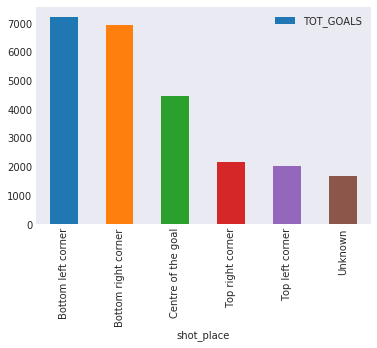

In [32]:
# Plot above answer by converting to pandas dataframe
res1 = que1.toPandas()

plot1 = res1.plot.bar(x='shot_place', y='TOT_GOALS')

Ans - Maximum goals are scored at the Bottom left corner and followed by Bottom right corner by most of the teams in tournaments

In [33]:
#Que 2. Which countries have scored maximum no. of goals in all tournaments ?
que2 = spark.sql("SELECT country, COUNT(1) AS TOT_GOALS FROM soccer WHERE is_goal = 1 GROUP BY country\
                    ORDER BY 2 DESC")
que2.show()

+-------+---------+
|country|TOT_GOALS|
+-------+---------+
|  spain|     5583|
|  italy|     5491|
| france|     5199|
|germany|     4621|
|england|     3552|
+-------+---------+



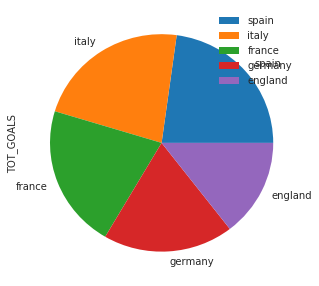

In [34]:
# Plot above result in pie chart
res2 = que2.toPandas()

plot2 = res2.plot.pie(y='TOT_GOALS', labels =res2.country, figsize=(5, 5))

Ans - Spain is the topper among all the countries in terms of no. of goals in all tournaments

In [35]:
# Que 3. At what minutes most number of goals are scored?
que3 = spark.sql("SELECT time, count(1) as num_of_goals FROM soccer WHERE is_goal = 1 GROUP BY time ORDER BY 2 DESC LIMIT 10")
                 
que3.show()


+----+------------+
|time|num_of_goals|
+----+------------+
|  90|        1244|
|  45|         594|
|  56|         339|
|  72|         308|
|  50|         307|
|  86|         306|
|  73|         306|
|  88|         305|
|  61|         304|
|  55|         300|
+----+------------+



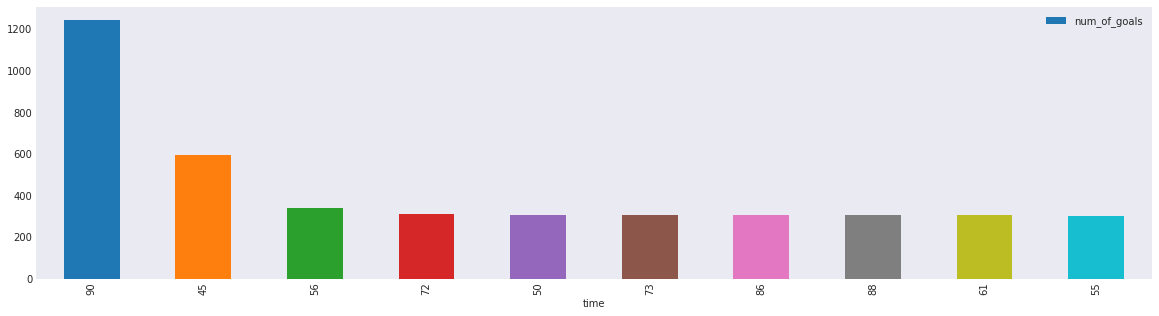

In [36]:
# Plot above result
res3 = que3.toPandas()

plot3 = res3.plot.bar(x='time', y='num_of_goals', figsize=(20,5))

Ans - No. of goals scored are highest in the 90th and 45th Minute, but please check below results before coming to any conclusion

In [37]:
# Que3: Analyze time ranges maximum number of goals are scored
que3_ = spark.sql("SELECT time_bin, count(1) as num_of_goals FROM soccer \
                    WHERE is_goal = 1 GROUP BY time_bin ORDER BY 1")
                 
que3_.show()

+--------+------------+
|time_bin|num_of_goals|
+--------+------------+
|     0.0|        2161|
|     1.0|        2331|
|     2.0|        2636|
|     3.0|        2245|
|     4.0|        2572|
|     5.0|        2530|
|     6.0|        2507|
|     7.0|        2235|
|     8.0|        2541|
|     9.0|        2688|
+--------+------------+



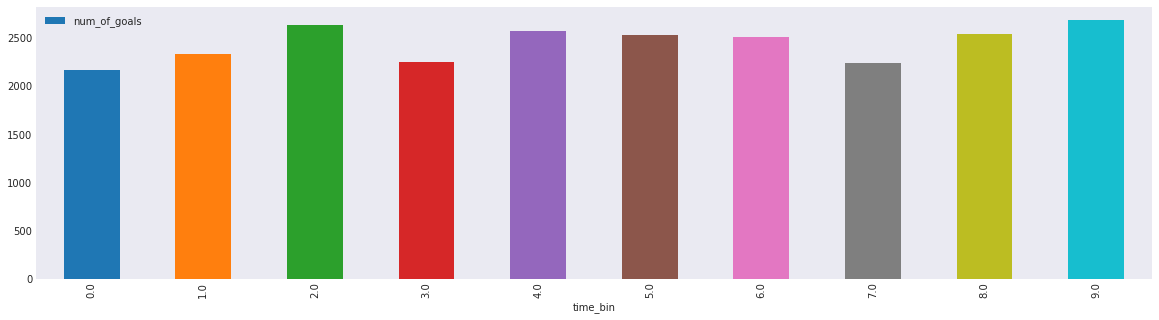

In [38]:
# Plot above result
res3_ = que3_.toPandas()

plot3_ = res3_.plot.bar(x='time_bin', y='num_of_goals', figsize=(20,5))

When no. of goals are plotted against time bins, we can see that the goal distributions is similar across different time frames from 0th to 90th minute in game.

In [39]:
# Que 4. At what minutes maximum number of yellow card were given ?
que4 = spark.sql("SELECT time, count(1) as num_of_yellow_cards FROM soccer \
                WHERE event_type_str == 'Yellow card' OR event_type_str == 'Second yellow card' \
                GROUP BY time ORDER BY 2 DESC LIMIT 10")
                 
que4.show()

+----+-------------------+
|time|num_of_yellow_cards|
+----+-------------------+
|  90|               2784|
|  45|               1106|
|  88|                686|
|  89|                650|
|  87|                624|
|  86|                618|
|  84|                593|
|  85|                592|
|  80|                588|
|  83|                585|
+----+-------------------+



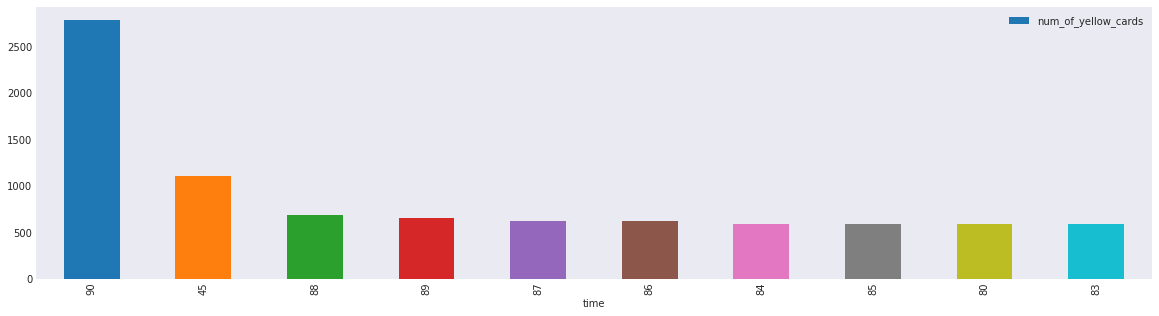

In [40]:
# Plot above result
res4 = que4.toPandas()

plot4 = res4.plot.bar(x='time', y='num_of_yellow_cards', figsize=(20,5))

Ans - No. of yellow cards are highest during the nervous 90's and then during the mid time

In [41]:
# Que4: Analyze time ranges when maximum yellow cards are given
que4_ = spark.sql("SELECT time_bin, count(1) as num_of_yellow_cards FROM soccer \
                WHERE event_type_str == 'Yellow card' OR event_type_str == 'Second yellow card' \
                GROUP BY time_bin ORDER BY 1")
                 
que4_.show()

+--------+-------------------+
|time_bin|num_of_yellow_cards|
+--------+-------------------+
|     0.0|               1319|
|     1.0|               2429|
|     2.0|               3991|
|     3.0|               3960|
|     4.0|               4209|
|     5.0|               4295|
|     6.0|               4683|
|     7.0|               4192|
|     8.0|               5007|
|     9.0|               5926|
+--------+-------------------+



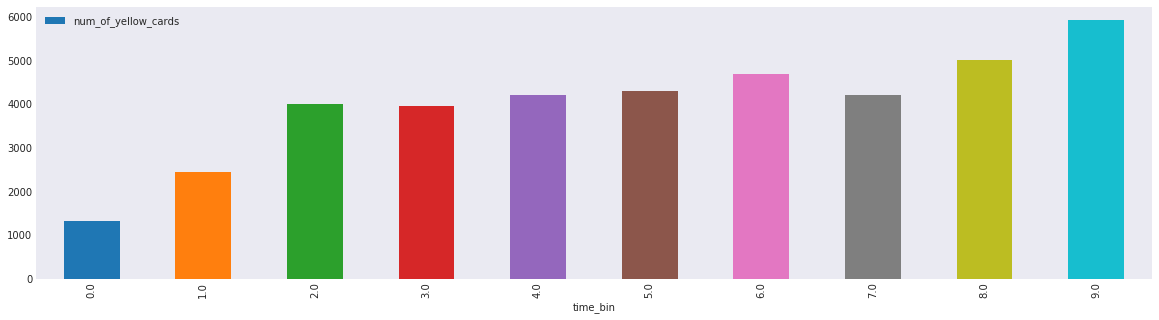

In [42]:
# Plot above result
res4_ = que4_.toPandas()

plot4_ = res4_.plot.bar(x='time_bin', y='num_of_yellow_cards', figsize=(20,5))

The time bin distribution depicts the similar story that, yellow card are given more during the last minutes but they are also given during the mid game

In [43]:
# Que 5. At what minutes maximum number of red card were given ?
que5 = spark.sql("SELECT time, count(1) as num_of_red_card FROM soccer \
                WHERE event_type_str == 'Red card' \
                GROUP BY time ORDER BY 2 DESC LIMIT 10")
                 
que5.show()

+----+---------------+
|time|num_of_red_card|
+----+---------------+
|  90|            165|
|  82|             29|
|  86|             28|
|  45|             27|
|  83|             25|
|  64|             25|
|  81|             24|
|  72|             22|
|  80|             22|
|  85|             21|
+----+---------------+



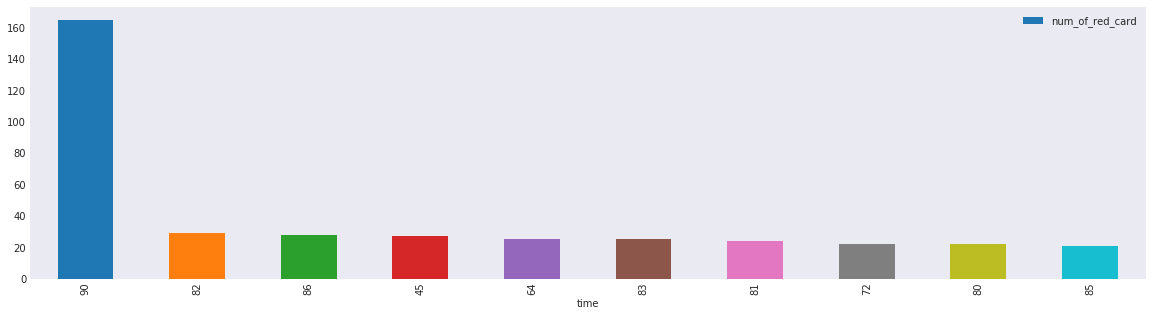

In [44]:
# Plot above result
res5 = que5.toPandas()

plot5 = res5.plot.bar(x='time', y='num_of_red_card', figsize=(20,5))

Ans - Red cards are given most during the last minutes in the game

In [45]:
# Que5: Analyze time ranges when maximum red cards are given
que5_ = spark.sql("SELECT time_bin, count(1) as num_of_red_card FROM soccer \
                WHERE event_type_str == 'Red card' \
                GROUP BY time_bin ORDER BY 1")
                 
que5_.show()

+--------+---------------+
|time_bin|num_of_red_card|
+--------+---------------+
|     0.0|             44|
|     1.0|             60|
|     2.0|             94|
|     3.0|             70|
|     4.0|             92|
|     5.0|             95|
|     6.0|            130|
|     7.0|            101|
|     8.0|            191|
|     9.0|            275|
+--------+---------------+



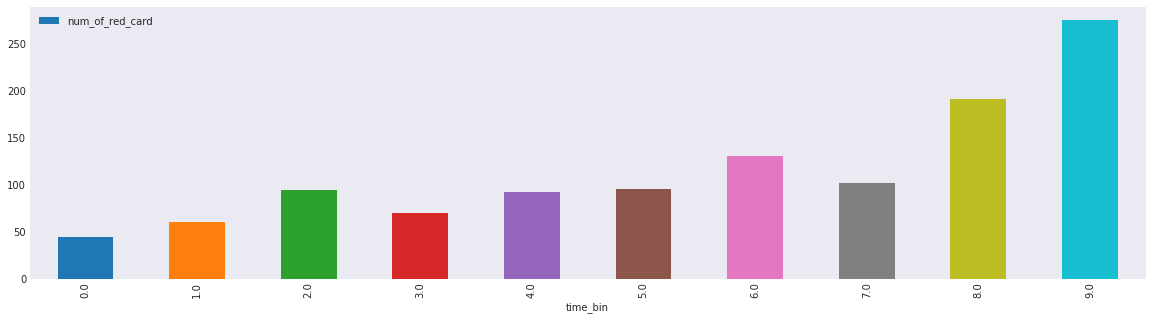

In [46]:
# Plot above result
res5_ = que5_.toPandas()

plot5_ = res5_.plot.bar(x='time_bin', y='num_of_red_card', figsize=(20,5))

Result in time bin tells same story that Red card are highest during the last minutes of the game.

In [47]:
# Que 6. At what time most number of substitution were made ?
que6 = spark.sql("SELECT time, count(1) as total_substitutions FROM soccer \
                WHERE event_type_str == 'Substitution' \
                GROUP BY time ORDER BY 2 DESC LIMIT 10")
                 
que6.show()

+----+-------------------+
|time|total_substitutions|
+----+-------------------+
|  45|               3645|
|  90|               1704|
|  78|               1557|
|  77|               1530|
|  76|               1506|
|  81|               1501|
|  74|               1485|
|  70|               1461|
|  80|               1460|
|  79|               1459|
+----+-------------------+



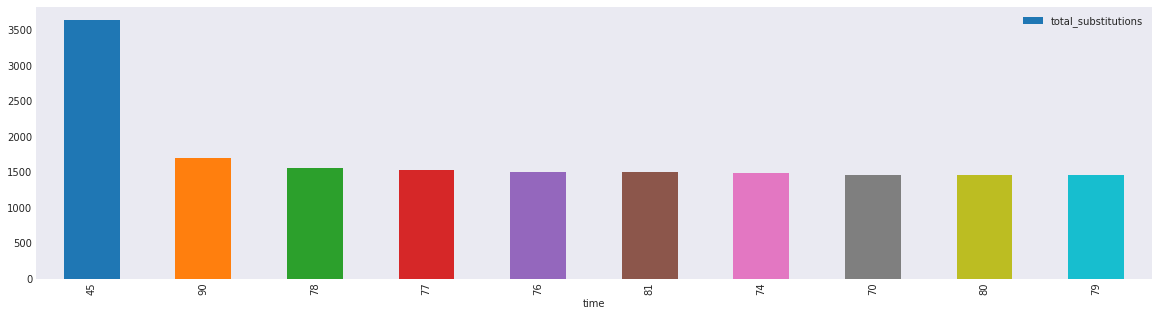

In [48]:
# Plot above result
res6 = que6.toPandas()

plot6 = res6.plot.bar(x='time', y='total_substitutions', figsize=(20,5))

Ans - Most substitutions happen suring mid time and end time in game

In [49]:
# Que6: Analyze time ranges when maximum substitutions are done
que6_ = spark.sql("SELECT TIME_BIN, count(1) as total_substitutions FROM soccer \
                WHERE event_type_str == 'Substitution' \
                GROUP BY TIME_BIN ORDER BY 1")
                 
que6_.show()

+--------+-------------------+
|TIME_BIN|total_substitutions|
+--------+-------------------+
|     0.0|                283|
|     1.0|                441|
|     2.0|                710|
|     3.0|                658|
|     4.0|               4233|
|     5.0|               4720|
|     6.0|              10517|
|     7.0|              11488|
|     8.0|              12745|
|     9.0|               5943|
+--------+-------------------+



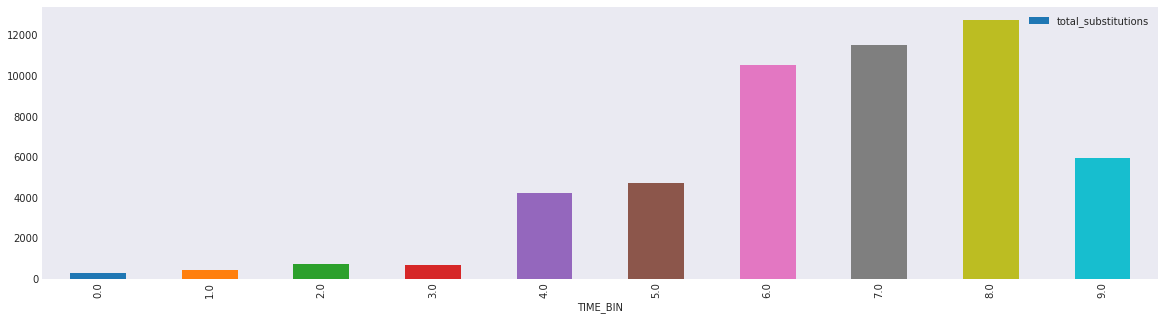

In [50]:
# Plot above result
res6_ = que6_.toPandas()

plot6_ = res6_.plot.bar(x='TIME_BIN', y='total_substitutions', figsize=(20,5))

Ans - The distribution of no. of substitutions along the time bins tells that they are most during the 80th minute in game

In [51]:
# Que 7. Goal wise distribution of Location and shot place for 'Spain'
que7 = spark.sql("SELECT shot_place, location, TOT_GOALS FROM ( \
                    SELECT shot_place, location, TOT_GOALS, \
                    RANK() OVER (PARTITION BY shot_place ORDER BY TOT_GOALS DESC) goals_rank \
                    FROM ( \
                          SELECT \
                          CASE WHEN shot_place_str = 'NA' THEN 'Unknown' ELSE shot_place_str END AS shot_place, \
                          CASE WHEN location_str = 'NA' THEN 'Unknown' ELSE location_str END AS location, \
                          COUNT(1) AS TOT_GOALS \
                          FROM soccer \
                          WHERE is_goal = 1 AND COUNTRY_CODE = 'ESP' \
                          GROUP BY shot_place_str, location_str \
                    ) tmp_in \
                    WHERE TOT_GOALS IS NOT NULL AND TOT_GOALS <> 0 \
                 ) tmp_out \
                WHERE goals_rank <= 3 AND location != 'Unknown' AND shot_place != 'Unknown' ORDER BY shot_place")
que7.show()

+-------------------+--------------------+---------+
|         shot_place|            location|TOT_GOALS|
+-------------------+--------------------+---------+
| Bottom left corner|   Centre of the box|      832|
| Bottom left corner|    Very close range|      219|
| Bottom left corner|     Outside the box|      166|
|Bottom right corner|    Very close range|      174|
|Bottom right corner|   Centre of the box|      813|
|Bottom right corner|     Outside the box|      163|
| Centre of the goal|   Centre of the box|      429|
| Centre of the goal|        Penalty spot|       65|
| Centre of the goal|    Very close range|      275|
|    Top left corner|    Very close range|       56|
|    Top left corner|   Centre of the box|      172|
|    Top left corner|     Outside the box|       63|
|   Top right corner|   Centre of the box|      178|
|   Top right corner|     Outside the box|       74|
|   Top right corner|Left side of the box|       48|
+-------------------+--------------------+----

Ans - above list can provide spain tema analyze what are their shot places and locations in the filed where the score the most or least

In [52]:
temp = spark.sql("SELECT distinct(country) \
                  FROM soccer \
                  WHERE is_goal == 1 \
                 ORDER BY 1 ")
temp.show()

+-------+
|country|
+-------+
|england|
| france|
|germany|
|  italy|
|  spain|
+-------+



In [53]:
# Que 8. Goal distribution in different time bins for all countries- time bins from 0.0 i.e min 1- 10 till 9.0 i,e min 8.0 to 9.0
que8 = spark.sql("SELECT country, TIME_BIN, COUNT(1) TOT_GOALS \
                  FROM soccer \
                  WHERE is_goal = 1 \
                  GROUP BY country, TIME_BIN \
                  ORDER BY country, TIME_BIN")
que8.show()

+-------+--------+---------+
|country|TIME_BIN|TOT_GOALS|
+-------+--------+---------+
|england|     0.0|      289|
|england|     1.0|      364|
|england|     2.0|      364|
|england|     3.0|      320|
|england|     4.0|      422|
|england|     5.0|      353|
|england|     6.0|      385|
|england|     7.0|      309|
|england|     8.0|      354|
|england|     9.0|      392|
| france|     0.0|      455|
| france|     1.0|      490|
| france|     2.0|      506|
| france|     3.0|      484|
| france|     4.0|      567|
| france|     5.0|      504|
| france|     6.0|      535|
| france|     7.0|      492|
| france|     8.0|      535|
| france|     9.0|      631|
+-------+--------+---------+
only showing top 20 rows



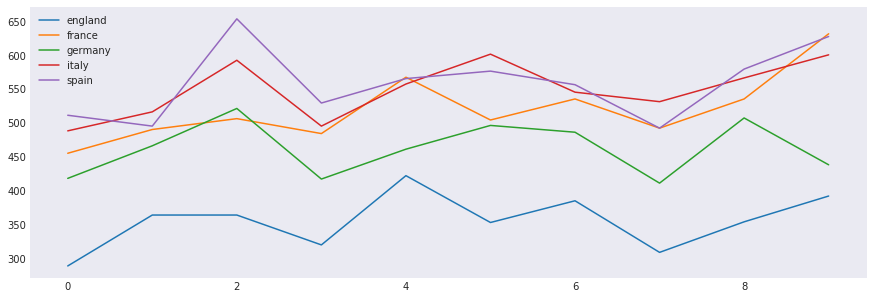

In [54]:
res8 = que8.toPandas()
# Get no of goals for time bin for each country to crteate dataframe to show trend line graph
england = res8[res8['country']=='england']
#england.TOT_GOALS
france = res8[res8['country']=='france']
#print(france.TOT_GOALS)
germany = res8[res8['country']=='germany']
#print(germany.TOT_GOALS)
italy = res8[res8['country']=='italy']
#print('italy',italy.TOT_GOALS)
spain = res8[res8['country']=='spain']
#print('spain',spain.TOT_GOALS)

# Create pandas dataframe
df = pd.DataFrame({
    'england': [289, 364, 364, 320, 422, 353, 385, 309, 354, 392],
    'france': [455, 490, 506, 484, 567, 504, 535, 492, 535, 631],
    'germany': [418, 466, 521, 417, 461, 496, 486, 411, 507, 438],
    'italy': [488, 516, 592, 495, 557, 601, 545, 531, 566, 600],
    'spain': [511, 495, 653, 529, 565, 576, 556, 492, 579, 627]},
    index=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])
lines = df.plot.line(figsize=(15,5))

Interpretation from above trend:
- From above graph we can see that, england starts with low goal scores and tend to gain a little traction during mid and end minutes of the game.
- Germany's goal distribution is quiet even throughout the game but loses goal scores mostly at the end
- Same with France but they tend to score goals in last minutes often
- Italy has good progress as compared to others throughout the game
- Whereas Spain tends to score most of their goals at the start, while they slow down in mid minutes of the game, roaring at the end. So the opponent countries should try to stop them at the start of the game if they want to win it.